In [1]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F
from torch import distributions as pyd

from utils import util, buffer
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from utils import util, buffer
import pickle

/home/geert/anaconda3/envs/mixer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/geert/anaconda3/envs/mixer/lib/python3.8/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [7]:
def load_rat7m():
    state_dim = 8
    action_dim = 8
    replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000)
    replay_buffer_path = f'../../rat7m/replay_buffer_3sigma_tanh.pth'
    replay_buffer.load_state_dict(torch.load(replay_buffer_path))
    print(f'Replay buffer loaded from {replay_buffer_path}')
    return replay_buffer, state_dim, action_dim
replay_buffer, state_dim, action_dim = load_rat7m()
print(replay_buffer.state[:5], replay_buffer.action[:5])

Replay buffer loaded from ../../rat7m/replay_buffer_3sigma_tanh.pth
[[123.7345 200.4987  65.4375   1.6622   2.1916   2.9454   2.2586   1.2536]
 [122.0299 200.5316  65.018    2.2142   1.0883  -0.2754  -1.4034  -0.4355]
 [121.6406 204.4449  64.7374   2.1142   0.8841   0.8824  -0.7641  -0.3044]
 [119.6549 208.4292  63.5946   2.2176   0.7737   0.8069  -0.8365  -0.6493]
 [115.8762 211.75    62.8877   2.2768   0.7703   0.8167  -0.821   -0.8076]] [[-0.34454262  0.00763125 -0.12247826  0.31052968 -0.99996726 -1.
  -1.         -0.99917449]
 [-0.08144281  0.69766468 -0.082172   -0.05811319 -0.76975863  0.99953365
   0.96095639  0.29358702]
 [-0.39572373  0.70560781 -0.32321757  0.06007965 -0.50147558 -0.26604764
  -0.21815791 -0.66150799]
 [-0.66236116  0.62439099 -0.20446598  0.03442451 -0.01689035  0.03546069
   0.04748554 -0.34966728]
 [-0.58580544  0.60933533 -0.29857967  0.02343848  0.25035685  0.03509997
   0.12919138 -0.44434385]]


In [2]:
matrix_notxyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalized_lasso_1e-2/0/ig_matrix_agg.npy')
matrix_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
corr = np.corrcoef(matrix_notxyz.flatten(), matrix_xyz.flatten())[0, 1]
print(corr)

0.8587985840314173


In [5]:
import torch

phi_hidden_dim = 10
input_dim = 9  # suppose we have 2 groups, each with xyz => 2*3=6
W = torch.randn(phi_hidden_dim, input_dim)

# Original approach
W_orig = W.reshape(phi_hidden_dim, input_dim//3, 3)
orig_lasso = torch.sqrt(W_orig.pow(2).sum(dim=0).sum(dim=-1)).sum()

# New approach
W_t = W.T.reshape(-1, phi_hidden_dim*3)
new_lasso = torch.norm(W_t, dim=1).sum()

print("orig_lasso =", orig_lasso.item())
print("new_lasso  =", new_lasso.item())

orig_lasso = 17.054546356201172
new_lasso  = 17.054546356201172


In [10]:
state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
                'SpineL','HipL','HipR','ElbowL','ArmL',
                'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
                'KneeL','ShinL','ShinR']
# When I transfer the skeleton into edges, Please refer to the following skeleton.

state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
              'SpineL','HipL','HipR','ElbowL','ArmL',
              'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
              'KneeL','ShinL','ShinR']

skeleton = [('HeadF', 'HeadB'), ('HeadF', 'HeadL'), ('HeadB', 'HeadL'),
            ('HeadB', 'SpineF'), ('HeadL', 'SpineF'), ('SpineF', 'SpineM'),
            ('SpineM', 'SpineL'), ('SpineF', 'ShoulderL'), ('ShoulderL', 'ElbowL'),
            ('ElbowL', 'ArmL'), ('SpineF', 'ShoulderR'), ('ShoulderR', 'ElbowR'),
            ('ElbowR', 'ArmR'), ('SpineM', 'HipL'), ('HipL', 'KneeL'),
            ('KneeL', 'ShinL'), ('SpineM', 'HipR'), ('HipR', 'KneeR'),
            ('KneeR', 'ShinR')]
edges = []
for i in skeleton:
  edges.append((state_name.index(i[0]), state_name.index(i[1])))

import joblib
import numpy as np
import matplotlib.pyplot as plt
pca = joblib.load('./pca.p')
print(pca)

PCA()


/tmp/ipykernel_8790/2271248462.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


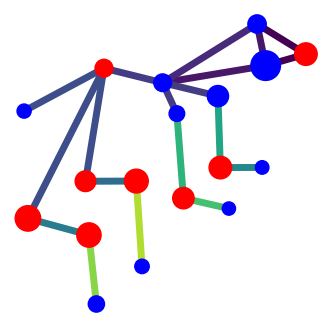

In [47]:
def center_embedding(n):
    """
    Generates a matrix ``Gamma`` that maps from a (n-1)-dimensional
    vector space  to the space of k-tuples with zero mean

    Parameters
    ----------
    n : int
        Number of keypoints.

    Returns
    -------
    Gamma: jax array of shape (n, n - 1)
        Matrix to map to centered embedded space.
    """
    X = np.tril(np.ones((n, n)), k=-1)[1:]
    X = np.eye(n)[1:] - X / X.sum(1)[:, None]
    X = X / np.sqrt((X**2).sum(1))[:, None]
    return X.T
Gamma = np.array(center_embedding(len(state_name)))

ymean = Gamma @ pca.mean_.reshape(len(state_name)-1, -1)
ymean[state_name.index('HeadB'), 2] -= 10
ymean[state_name.index('HeadF'), 0] += 10
ymean[state_name.index('SpineL'), 2] += 20
ymean[state_name.index('ShoulderL'), 0] += 20
ymean[state_name.index('ElbowL'), 0] += 20
ymean[state_name.index('ElbowL'), 2] += 10
ymean[state_name.index('ArmL'), 0] += 30
ymean[state_name.index('ArmL'), 2] += 10
ymean[state_name.index('ArmR'), 0] += 10
ymean[state_name.index('HipL'), 2] += 10
ymean[state_name.index('HipL'), 0] += 30
ymean[state_name.index('KneeL'), 2] += 10
ymean[state_name.index('KneeL'), 0] += 30
ymean[state_name.index('ShinL'), 2] += 10
ymean[state_name.index('ShinL'), 0] += 30
ymean[state_name.index('HipR'), 0] -= 10
ymean[state_name.index('HipR'), 2] += 10
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
dims = [0, 2]
dims, name = [0,2], 'xz'
cmap = plt.cm.get_cmap('viridis')
keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
# print(keypoint_colors)
n_bodyparts = len(state_name)
ig_matrix_agg_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
for e in edges:
    axes.plot(
        *ymean[:, dims][e,:].T,
        color=keypoint_colors[e[0]],
        linewidth=5.0,
        zorder=0)
node_colors = ['blue' if ig_matrix_agg_xyz[0, j] < 0 else 'red' for j in range(2*n_bodyparts)]
axes.scatter(
        *ymean[:, dims].T,
        c=node_colors[:n_bodyparts],
        s=np.abs(ig_matrix_agg_xyz[0, :n_bodyparts])*120,
        zorder=1)
axes.axis('off')
plt.show()

In [48]:
np.save('ymean.npy', ymean)